# Welcome to a Political Party, drinks may be served!


In [66]:
from final_2016 import pass_data

In [67]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import copy
from scipy.special import logit
from scipy.special import expit

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

from pyro.infer import MCMC, NUTS, Predictive

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from matplotlib import pyplot

NaN = float('nan')

In [68]:
# Creation of a covariance matrix of size (n, n) with variance sigma2 
def cov_matrix(n, sigma2, rho):
        m = np.ones(shape=(n,n)) * rho
        m2 = np.zeros(shape=(n,n))

        np.fill_diagonal(m, 1)
        np.fill_diagonal(m2, sigma2 ** .5) 
    
        return(np.matmul(np.matmul(m2, m), m2))

def check_cov_matrix(mat, weights):
        diag = np.diag(mat)

# Fitting RMSE linear regression with hardcoded param values & hyper param values
def fit_rmse_day_x(x):
        y = []
        for num in x:
                y.append( 0.03 + (10 **(-6.6)) * (num ** 2) )
        return y

In [180]:
def model(data, polls=None):
    #data from data dictionary

    #X
    N_national_polls = data["N_national_polls"] #Number of National Polls
    N_state_polls = data["N_state_polls"] #Number of State Polls
    T = data["T"] #Number of days
    S = data["S"] #Number of states for which at-least 1 poll is available
    P = data["P"] #Number of pollsters
    M = data["M"] #Number of poll modes
    Pop = data["Pop"] #Number of poll populations
    state = data["state"] #state index
    day_state = data["day_state"] #State Day index
    day_national = data["day_national"] #National Day index
    poll_state = data["poll_state"] #State Pollster Index
    poll_national = data["poll_national"] #National Pollster Index
    poll_mode_state = data["poll_mode_state"] #State Poll Mode Index
    poll_mode_national = data["poll_mode_national"] #National Poll Model Index
    poll_pop_state = data["poll_pop_state"] #State poll population
    poll_pop_national = data["poll_pop_national"] #National Poll Populaiton
    unadjusted_national = data["unadjusted_national"] 
    unadjusted_state = data["unadjusted_state"] 
    n_two_share_national = data["n_two_share_national"] #Total Number of Dem+Reb supporters for a particular poll
    n_two_share_state = data["n_two_share_state"] #Total Number of Dem+Reb supporters for a particular poll
    
    #y
    if polls is not None:
        n_democrat_national = polls["n_democrat_national"] #Number of Dem supporters in national poll for a particular poll 
        n_democrat_state = polls["n_democrat_state"] #Number of Dem supporters in state poll for a particular poll
    else:
        n_democrat_national = None
        n_democrat_state = None
    
    #Prior Input values
    mu_b_prior = data["mu_b_prior"]
    state_weights = data["state_weights"]
    sigma_c = data["sigma_c"]
    sigma_m = data["sigma_m"]
    sigma_pop = data["sigma_pop"]
    sigma_measure_noise_national = data["sigma_measure_noise_national"]
    sigma_measure_noise_state = data["sigma_measure_noise_state"]
    sigma_e_bias = data["sigma_e_bias"]

    #Covariance Matrix and Scale Input
    state_covariance_0 = data["state_covariance_0"]
    random_walk_scale = data["random_walk_scale"]
    mu_b_T_scale = data["mu_b_T_scale"]
    polling_bias_scale = data["polling_bias_scale"]

    #Data Transformation
    national_cov_matrix_error_sd = torch.sqrt(torch.tensor(state_weights.T @ state_covariance_0 @ state_weights))

    #Scale Covariance
    ss_cov_poll_bias = torch.tensor((((polling_bias_scale/national_cov_matrix_error_sd)**2).item() * state_covariance_0).values)
    ss_cov_mu_b_T = torch.tensor((((mu_b_T_scale/national_cov_matrix_error_sd)**2).item() * state_covariance_0).values)
    ss_cov_mu_b_walk = torch.tensor((((random_walk_scale/national_cov_matrix_error_sd)**2).item() * state_covariance_0).values)

    #Cholesky Transformation
    cholesky_ss_cov_poll_bias = torch.cholesky(ss_cov_poll_bias)
    cholesky_ss_cov_mu_b_T = torch.cholesky(ss_cov_mu_b_T)
    cholesky_ss_cov_mu_b_walk = torch.cholesky(ss_cov_mu_b_walk)

    #Priors
    #Parameters
    with pyro.plate("raw_mu_b_T-plate", size = S):
        raw_mu_b_T = pyro.sample("mu_b_T", dist.Normal(0., 1.))
        #assert raw_mu_b_T.shape == (S,)

    with pyro.plate("raw_mu_b_x-asis", size = S):
        with pyro.plate("raw_mu_b_y-plate", size = T):
            raw_mu_b = pyro.sample("mu_b_Temp", dist.Normal(0., 1.)) 
            raw_mu_b.transpose(0,1).flatten()
           #raw_mu_b.t().flatten() #Matrix to Column Order Vector
    
    with pyro.plate("raw_mu_c-plate", size = P):
        raw_mu_c = pyro.sample("raw_mu_c", dist.Normal(0., 1.))

    with pyro.plate("raw_mu_m-plate", size = M):
        raw_mu_m = pyro.sample("mu_m", dist.Normal(0., 1.))

    with pyro.plate("raw_mu_pop-plate", size = Pop):
        raw_mu_pop = pyro.sample("raw_mu_pop", dist.Normal(0., 1.))

    #!Not sure if this satisfies Offset=0 and multiplier=0.02
    mu_e_bias = pyro.sample("mu_e_bias", dist.Normal(0., 0.02))*0.02 

    #!Need to find way to add constraint lower = 0, upper = 1
    rho_e_bias = pyro.sample("rho_e_bias", dist.Normal(0.7, 0.1)) 

    with pyro.plate("raw_e_bias-plate", size = T):
        raw_e_bias = pyro.sample("raw_e_bias", dist.Normal(0., 1.))

    with pyro.plate("raw_measure_noise_national-plate", size = N_national_polls):
        raw_measure_noise_national = pyro.sample("measure_noise_national", dist.Normal(0., 1.))
    
    with pyro.plate("raw_measure_noise_state-plate", size = N_state_polls):
        raw_measure_noise_state = pyro.sample("measure_noise_state", dist.Normal(0., 1.))

    with pyro.plate("raw_polling_bias-plate", size = S):
        raw_polling_bias = pyro.sample("polling_bias", dist.Normal(0., 1.))

    #Transformed Parameters
    mu_b = pyro.param('mu_b', torch.empty(S, T)) #initalize mu_b
#    mu_b[:,T] = cholesky_ss_cov_mu_b_T @ raw_mu_b_T + mu_b_prior
#    for i in range(1,T):
#        mu_b[:, T - i] = cholesky_ss_cov_mu_b_walk @ raw_mu_b[:, T - i] + mu_b[:, T + 1 - i]
    
    mu_c = pyro.param('mu_c', raw_mu_c * sigma_c)
    mu_m = pyro.param('mu_m2', raw_mu_m * sigma_m) # mu_m is already in the trace as a sample
    mu_pop = pyro.param('mu_pop', raw_mu_pop * sigma_pop)
    sigma_rho = pyro.param('sigma_rho', torch.sqrt(1-(rho_e_bias)**2) * sigma_e_bias)

    e_bias = pyro.param('e_bias', torch.empty(T)) #initalize e_bias
#    e_bias[1] = raw_e_bias[1] * sigma_e_bias
 #   for t in range(1,T):
  #      e_bias[t] = mu_e_bias + rho_e_bias * (e_bias[t - 1] - mu_e_bias) + raw_e_bias[t] * sigma_rho

    # polling_bias is already in the trace as a sample
'''
    polling_bias2 = pyro.param('polling_bias2', cholesky_ss_cov_poll_bias.double() @ raw_polling_bias.double())
    mu_b_Transpose = mu_b.t().detach() # type conversion satisfaction
    state_weights = torch.Tensor(state_weights.values) # type conversion satisfaction 
    national_mu_b_average = pyro.param('national_mu_b_average', mu_b_Transpose @ state_weights)
    national_polling_bias_average = pyro.param('national_polling_bias_average',
                                               polling_bias2.T.double() @ state_weights.double())

    logit_pi_democrat_state = pyro.param('logit_pi_democrat_state', torch.empty(N_state_polls))
    logit_pi_democrat_national = pyro.param('logit_pi_democrat_national', torch.empty(N_national_polls))

#    print(len(logit_pi_democrat_state), len(state), len(day_state), len(poll_state), len(poll_mode_state), len(raw_measure_noise_state), len(polling_bias))

#    for i in range(1,N_state_polls+1):
    tempMax = len(poll_mode_state)
    logit_pi_democrat_national = logit_pi_democrat_national[:tempMax]
    logit_pi_democrat_state = logit_pi_democrat_state[:tempMax]
    for i in range(len(poll_mode_state)):
        logit_pi_democrat_state[i] = mu_b[state[i], day_state[i]] + mu_c[poll_state[i]] + mu_m[poll_mode_state[i]] + \
            mu_pop[poll_pop_state[i]] + unadjusted_state[i] * e_bias[day_state[i]] + raw_measure_noise_state[i] * sigma_measure_noise_state + \
            polling_bias2[state[i]]
        
    cross_term = torch.tensor(unadjusted_national).float() * e_bias[day_national] # type conversion
    logit_pi_democrat_national = national_mu_b_average[day_national] +  mu_c[poll_national] + mu_m[poll_mode_national][:tempMax] + \
        mu_pop[poll_pop_national] + cross_term + raw_measure_noise_national * sigma_measure_noise_national +\
        national_polling_bias_average
    
    
    n_two_share_state = torch.tensor(n_two_share_state)[:tempMax]
    #Likelihood Of the Model
    #!need to verify if this is the correct implementation for binomial_logit of stan
    
    #with pyro.plate("state-data-plate", size = N_state_polls):
    #with pyro.plate("state-data-plate", size = tempMax):
        #pyro.sample("n_democrat_state", dist.Binomial(n_two_share_state, logits = logit_pi_democrat_state), obs = n_democrat_state)
    
    n_two_share_national = torch.tensor(n_two_share_national)[:tempMax]
    #with pyro.plate("national-data-plate", size = N_national_polls):
    #with pyro.plate("national-data-plate", size = tempMax):
        #pyro.sample("n_democrat_national", dist.Binomial(n_two_share_national, logits = logit_pi_democrat_national), obs = n_democrat_national)
'''

'\n    polling_bias2 = pyro.param(\'polling_bias2\', cholesky_ss_cov_poll_bias.double() @ raw_polling_bias.double())\n    mu_b_Transpose = mu_b.t().detach() # type conversion satisfaction\n    state_weights = torch.Tensor(state_weights.values) # type conversion satisfaction \n    national_mu_b_average = pyro.param(\'national_mu_b_average\', mu_b_Transpose @ state_weights)\n    national_polling_bias_average = pyro.param(\'national_polling_bias_average\',\n                                               polling_bias2.T.double() @ state_weights.double())\n\n    logit_pi_democrat_state = pyro.param(\'logit_pi_democrat_state\', torch.empty(N_state_polls))\n    logit_pi_democrat_national = pyro.param(\'logit_pi_democrat_national\', torch.empty(N_national_polls))\n\n#    print(len(logit_pi_democrat_state), len(state), len(day_state), len(poll_state), len(poll_mode_state), len(raw_measure_noise_state), len(polling_bias))\n\n#    for i in range(1,N_state_polls+1):\n    tempMax = len(poll_mode_st

In [189]:
#!Need to modify this based on hyper-parameters used by the Original Model
def Inference_MCMC(model, data, polls, n_samples = 50, n_warmup = 50, n_chains = 1):
    print(type(data), type(polls))
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples = n_samples, warmup_steps = n_warmup, num_chains = n_chains)
    mcmc.run(data, polls)
    posterior_samples = mcmc.get_samples()

    hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

    return posterior_samples, hmc_samples


In [190]:
#Generate samples from posterior predictive distribution
def sample_posterior_predictive(model, posterior_samples, n_samples, data):
    posterior_predictive = Predictive(model, posterior_samples, num_samples = n_samples)
    posterior_predictive_samples = posterior_predictive.get_samples(data, None)

    return posterior_predictive

In [240]:
#Generating Quantity from posterior sample
def predicted_score(model, posterior_samples, data):
    T = data['T']
    S = data['S']
    predicted = torch.empty(T, S)
    posterior_predictive = Predictive(model, posterior_samples)
    trace  = posterior_predictive.get_vectorized_trace(data)
    print(trace.nodes.keys())
    mu_b = trace.nodes['mu_b']['value'].detach()
    for s in range(S):
        predicted[:,s] = expit(mu_b[s,:].t().flatten())

    return predicted

### Here we are using the pass_data( ) function from our final_2016.py helper python file in order to abstract the extensive & dull data preprocessing needed before feeding into the model

In [241]:
data, polls = pass_data()
model(data, polls)

[2016, 'black_pct', 'college_pct', 'hisp_other_pct', 'median_age', 'pct_white_evangel', 'pop_density', 'white_pct', 'wwc_pct'] [0.2162890087639303, 0.00396169583885996, 0.139747908727421, 0.0422148218437831, 30.5, 0.02923107672064036, 9.108415574117505, 0.222308740920812, 0.0250285919948363]
                            OLS Regression Results                            
Dep. Variable:                incvote   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     25.15
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.62e-05
Time:                        21:36:46   Log-Likelihood:                -41.736
No. Observations:                  18   AIC:                             89.47
Df Residuals:                      15   BIC:                             92.14
Df Model:                           2                                      

In [242]:
posterior_samples, hmc_samples = Inference_MCMC(model, data, polls)


Warmup:   0%|          | 0/100 [00:00, ?it/s]

<class 'dict'> <class 'dict'>


Sample: 100%|██████████| 100/100 [01:23,  1.20it/s, step size=1.42e-01, acc. prob=0.737]


In [243]:
posterior_predictive_samples = sample_posterior_predictive(model, posterior_samples, 52, data)


In [244]:
predictions = predicted_score(model, posterior_samples, data)

odict_keys(['_INPUT', 'raw_mu_b_T-plate', 'mu_b_T', 'raw_mu_b_x-asis', 'raw_mu_b_y-plate', 'mu_b_Temp', 'raw_mu_c-plate', 'raw_mu_c', 'raw_mu_m-plate', 'mu_m', 'raw_mu_pop-plate', 'raw_mu_pop', 'mu_e_bias', 'rho_e_bias', 'raw_e_bias-plate', 'raw_e_bias', 'raw_measure_noise_national-plate', 'measure_noise_national', 'raw_measure_noise_state-plate', 'measure_noise_state', 'raw_polling_bias-plate', 'polling_bias', 'mu_b', 'mu_c', 'mu_m2', 'mu_pop', 'sigma_rho', 'e_bias', '_RETURN'])


In [245]:
print(type(predictions))

<class 'torch.Tensor'>


In [246]:
print(len(predictions))

539


In [247]:
print(len(predictions[0]))

51


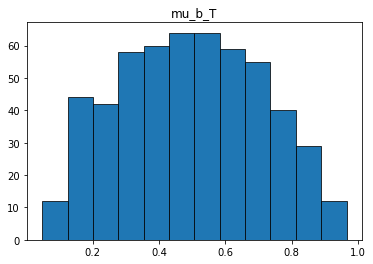

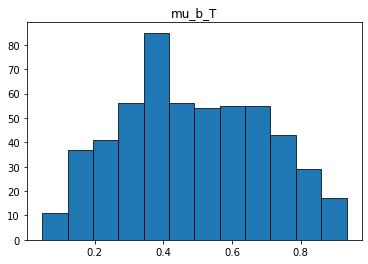

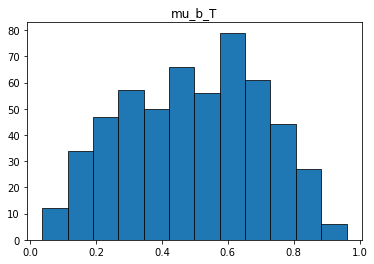

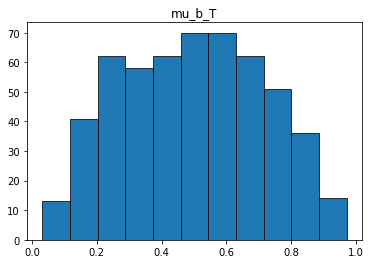

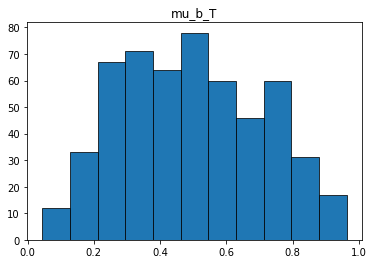

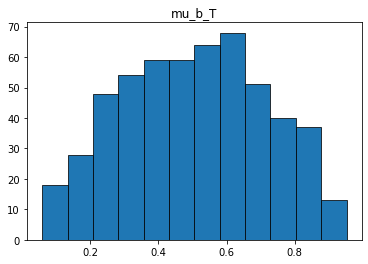

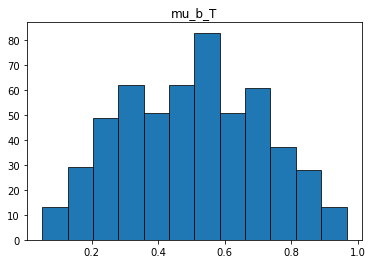

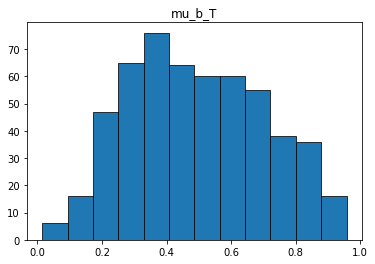

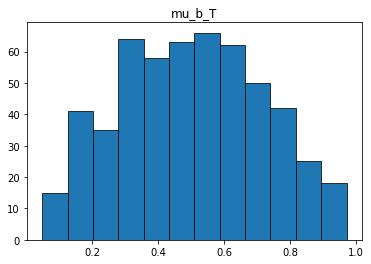

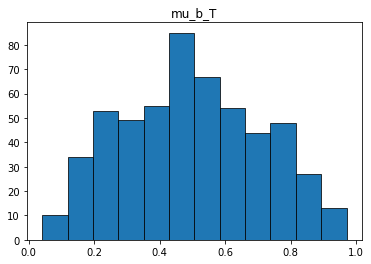

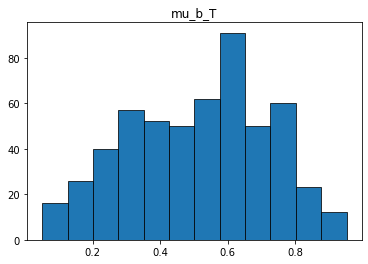

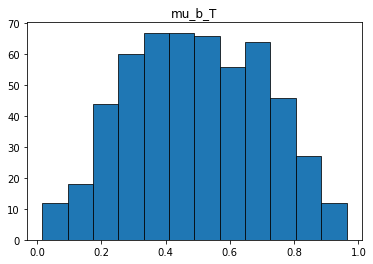

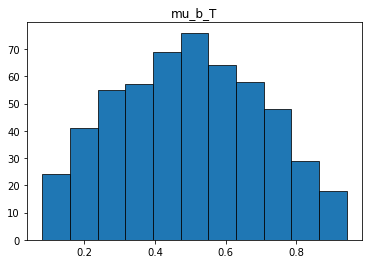

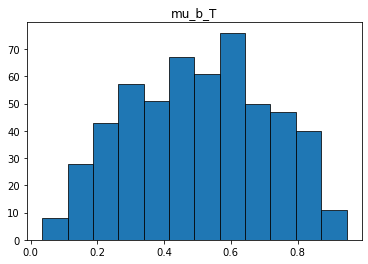

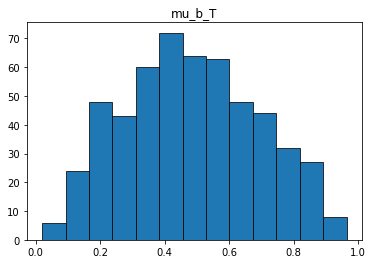

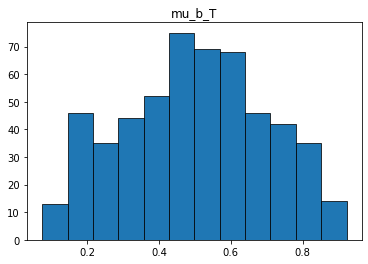

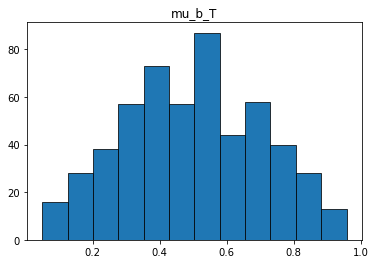

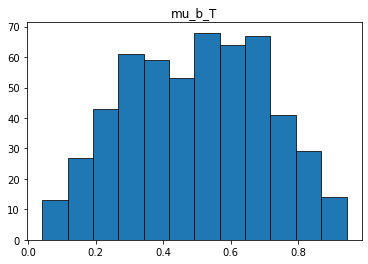

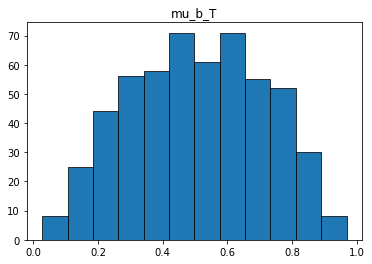

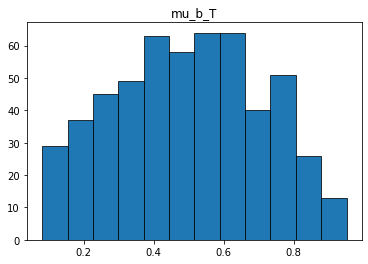

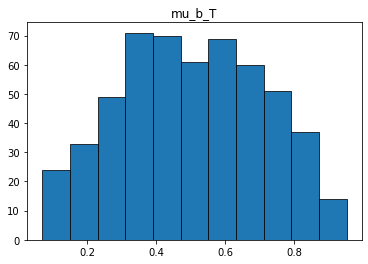

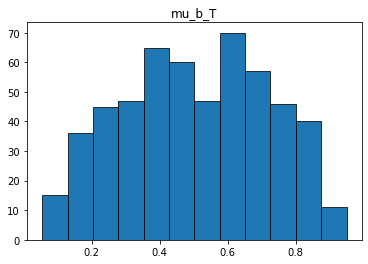

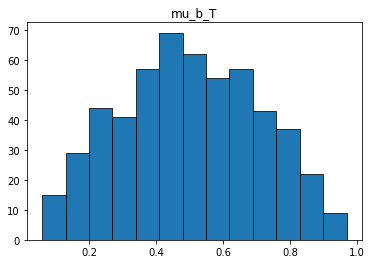

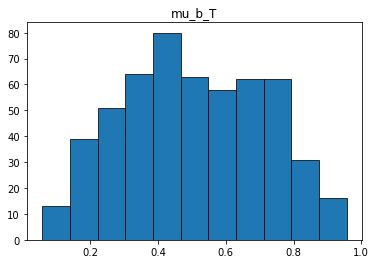

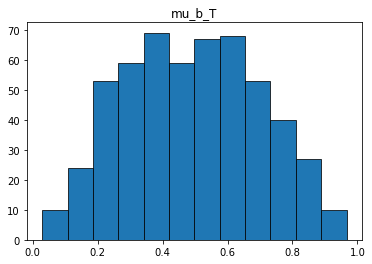

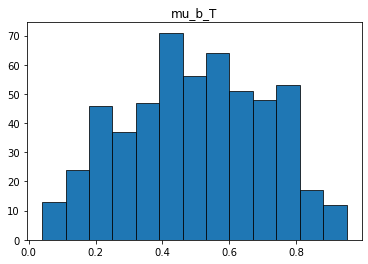

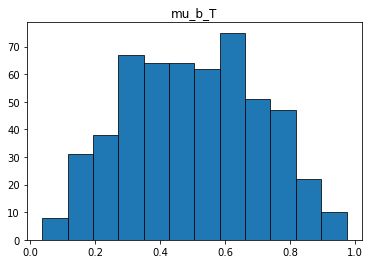

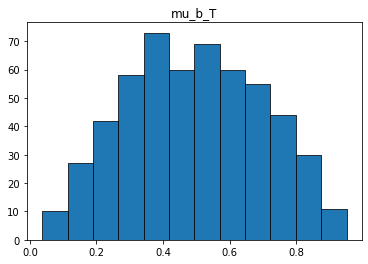

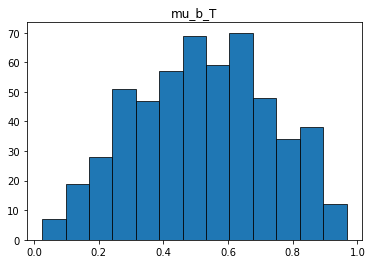

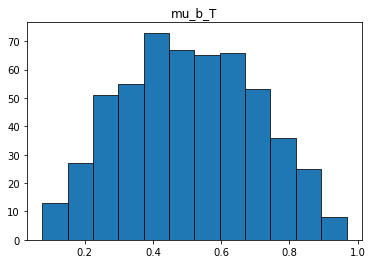

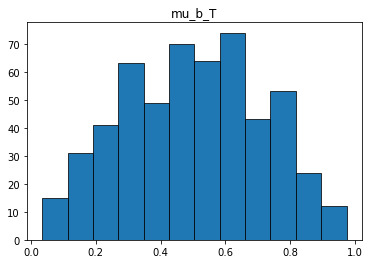

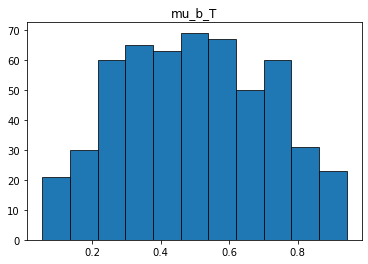

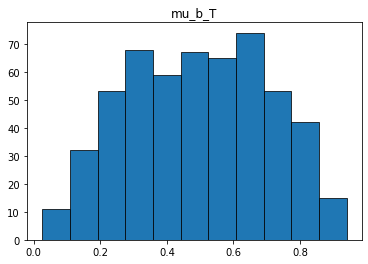

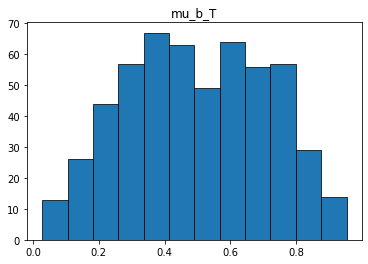

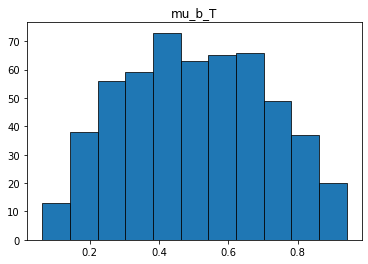

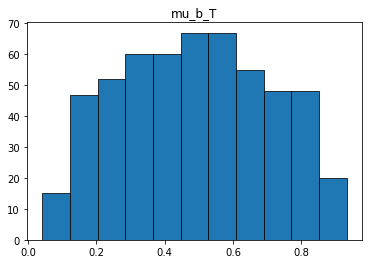

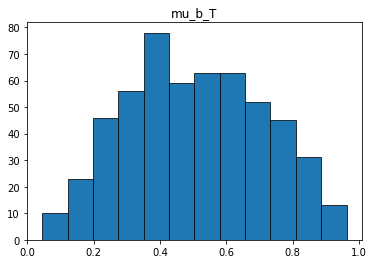

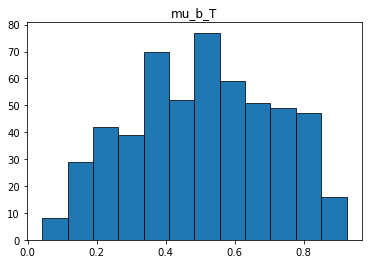

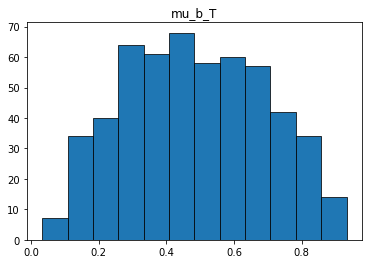

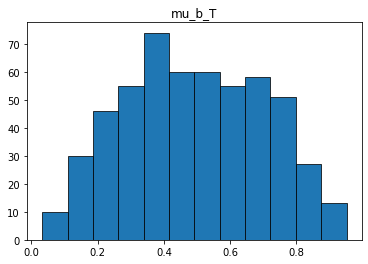

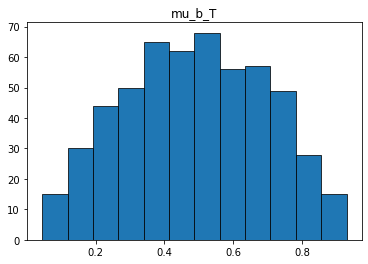

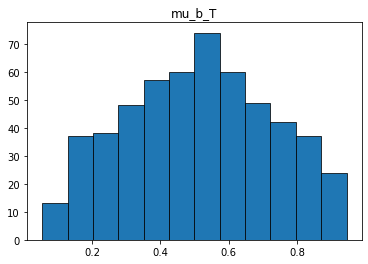

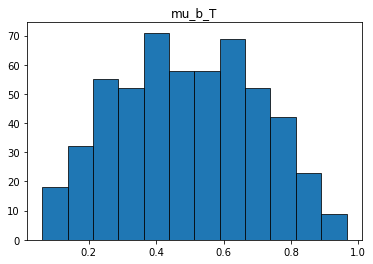

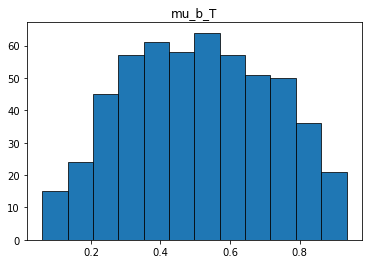

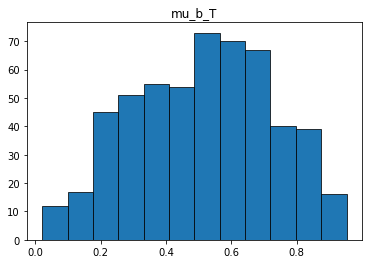

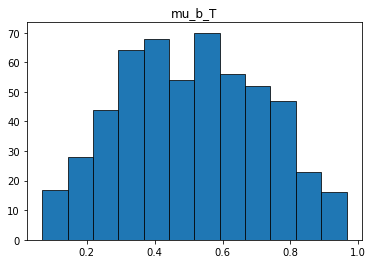

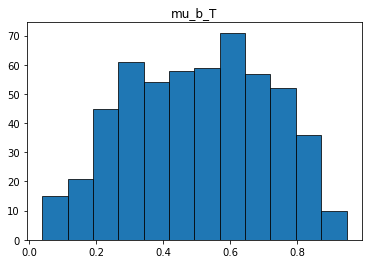

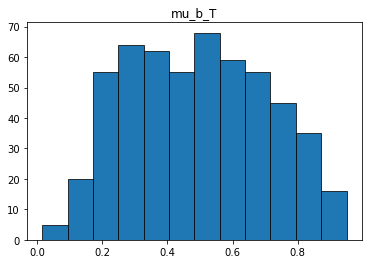

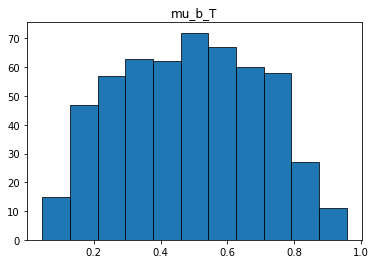

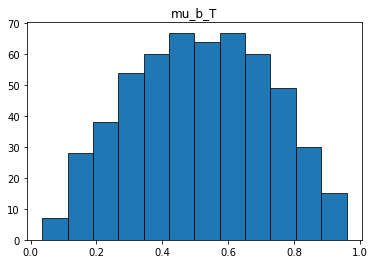

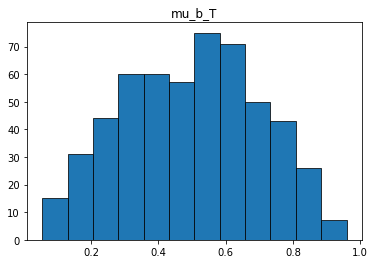

In [248]:
from collections import defaultdict


preds = defaultdict(list)
for i in range(len(predictions)):
    temp = predictions[i]
    for j in range(len(temp)):
        preds[j].append(temp[j])

for j in range(len(preds)):   
    plt.hist(preds[j], bins='auto', edgecolor='black', linewidth=0.75)
    plt.title("mu_b_T")
    plt.show()